In [1]:
import tensorflow as tf

# Pengecekan versi tensorflow yang digunakan
print(tf.__version__)

2.13.0


In [2]:
from sklearn.model_selection import train_test_split

# Function untuk pembagian dataset train dan validation
def splitDataset(dir, size):
    images = os.listdir(dir)
    x, y = train_test_split(images, test_size=size, random_state=1)
    return x, y

# Function untuk menyalin dataset
def copyDataset(source, dest, images, subdir):
    for img in images[subdir]:
        src = os.path.join(source, img)
        dst = os.path.join(dest, img)
        os.replace(src, dst)

# Function untuk training model
def trainModel(model, train_gen, val_gen, epochs):
    history = model.fit(
        train_gen,
        steps_per_epoch=len(train_gen),
        epochs=epochs,
        validation_data=val_gen,
        validation_steps=len(val_gen)
    )
    return history

In [3]:
import zipfile

# Ekstrak dataset
local_zip = 'rockpaperscissors.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('dataset/')
zip_ref.close()

In [4]:
import os

# Pendefinisian path untuk setiap direktori
base_dir = 'dataset/'
rps_dir = os.path.join(base_dir, 'rockpaperscissors')
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

In [5]:
# Pendefinisian daftar sub-direktori berdasarkan 3 kelas (rock, paper, scissors)
subdirectories = ['paper', 'rock', 'scissors']

# Inisialisasi variabel untuk menyimpan gambar train dan validation dari setiap kelas
train_images = {}
val_images = {}

for subdir in subdirectories:
    # Pembagian dataset untuk train dan validation dari setiap kelas dengan rasio 60:40
    train_images[subdir], val_images[subdir] = splitDataset(os.path.join(rps_dir, subdir), 0.4)

    # Pembuatan direktori untuk train dan validation dari setiap kelas
    os.makedirs(os.path.join(train_dir, subdir))
    os.makedirs(os.path.join(val_dir, subdir))

    # Penyalinan file gambar untuk train dan validation dari setiap kelas
    copyDataset(os.path.join(rps_dir, subdir), os.path.join(train_dir, subdir), train_images, subdir)
    copyDataset(os.path.join(rps_dir, subdir), os.path.join(val_dir, subdir), val_images, subdir)

# Pengecekan direktori train dan validation
print(f'Train Directory: {os.listdir(train_dir)}')
print(f'Validation Directory: {os.listdir(val_dir)}')

Train Directory: ['paper', 'rock', 'scissors']
Validation Directory: ['paper', 'rock', 'scissors']


In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Augmentasi gambar menggunakan ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(
    rescale=1./255
)

In [7]:
# Pembuatan generator untuk train set dan validation set dengan class categorical
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

print(train_generator.class_indices)

Found 1312 images belonging to 3 classes.
Found 876 images belonging to 3 classes.
{'paper': 0, 'rock': 1, 'scissors': 2}


In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Membangun model neural network sequential
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(3, activation='softmax')
])

# Menampilkan arsitektur model neural network yang telah dibangun
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)       0

In [9]:
# Compile model
model.compile(loss='categorical_crossentropy',
              optimizer=tf.optimizers.Adam(),
              metrics=['accuracy'])

In [10]:
import time

# Catat waktu mulai pelatihan
start_time = time.time()

# Pelatihan model
history = trainModel(model, train_generator, val_generator, 8)

# Total waktu pelatihan
print(f"Waktu pelatihan: {(time.time() - start_time):.2f} seconds")

Epoch 1/8
41/41 [==============================] - 59s 1s/step - loss: 1.1859 - accuracy: 0.3765 - val_loss: 1.0173 - val_accuracy: 0.3950
Epoch 2/8
41/41 [==============================] - 64s 2s/step - loss: 0.9552 - accuracy: 0.5297 - val_loss: 0.6238 - val_accuracy: 0.7580
Epoch 3/8
41/41 [==============================] - 90s 2s/step - loss: 0.6350 - accuracy: 0.7470 - val_loss: 0.2994 - val_accuracy: 0.9075
Epoch 4/8
41/41 [==============================] - 80s 2s/step - loss: 0.4668 - accuracy: 0.8239 - val_loss: 0.2237 - val_accuracy: 0.9384
Epoch 5/8
41/41 [==============================] - 53s 1s/step - loss: 0.3904 - accuracy: 0.8460 - val_loss: 0.3136 - val_accuracy: 0.9041
Epoch 6/8
41/41 [==============================] - 50s 1s/step - loss: 0.3802 - accuracy: 0.8628 - val_loss: 0.2029 - val_accuracy: 0.9475
Epoch 7/8
41/41 [==============================] - 51s 1s/step - loss: 0.3614 - accuracy: 0.8636 - val_loss: 0.2354 - val_accuracy: 0.9269
Epoch 8/8
41/41 [==========

In [11]:
# Evaluasi model
accuracy = history.history['accuracy'][-1] * 100
print(f'Akurasi model: {accuracy:.2f}%')

Akurasi model: 90.47%


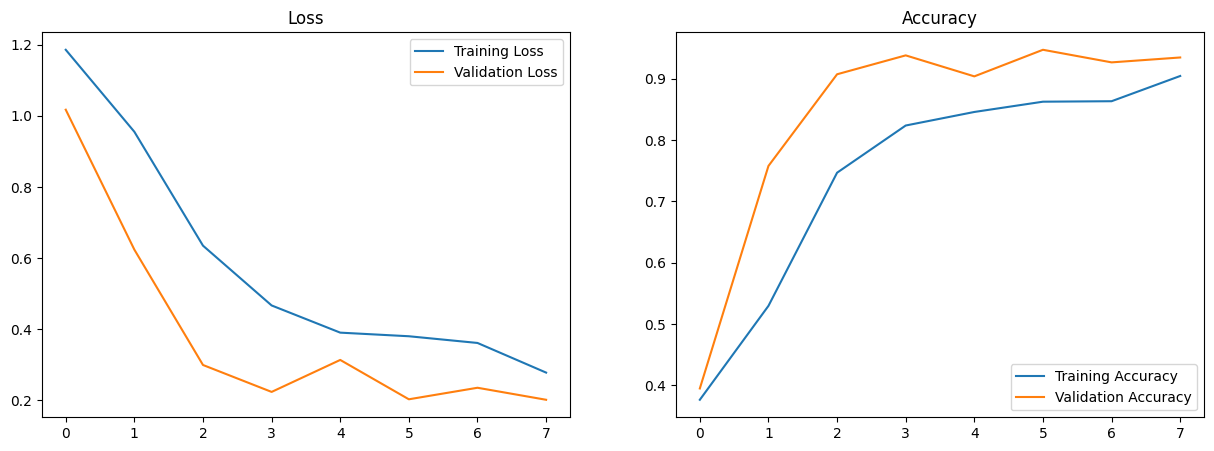

In [12]:
import matplotlib.pyplot as plt

# Pendefinisian variabel loss dan accuracy data history pelatihan
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plot grafik loss
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.title('Loss')

# Plot grafik accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()

Masukkan path file gambar lokal:  C:\Users\mrizk\Downloads\image.png


1/1 [==============================] - 0s 55ms/step


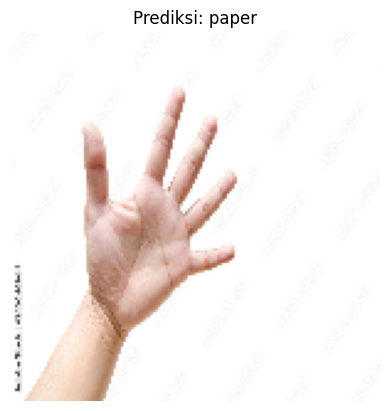

File: C:\Users\mrizk\Downloads\image.png
Prediksi: paper


In [15]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Mendefinisikan fungsi untuk memprediksi gambar
def predict_and_display_image(file_path):
    # Prediksi image
    img = image.load_img(file_path, target_size=(150, 150))

    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])

    classes = model.predict(images, batch_size=32)
    predicted_class = subdirectories[np.argmax(classes)]
    
    # Menampilkan gambar
    plt.imshow(img)
    plt.axis('off')  # Untuk menghilangkan sumbu x dan y
    plt.title(f'Prediksi: {predicted_class}')
    plt.show()

    return predicted_class

# Meminta user untuk memasukkan path file lokal
file_path = input("Masukkan path file gambar lokal: ")

# Melakukan prediksi untuk file yang diinputkan dan menampilkan gambar serta hasil prediksinya
predicted_class = predict_and_display_image(file_path)
print(f'File: {file_path}')
print(f'Prediksi: {predicted_class}')